<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [115]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, SGDRegressor, SGDClassifier, LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<font color=blue> *Several references from Kaggle Competition websites are used*</font>:
- [House Prices EDA](https://www.kaggle.com/dgawlik/house-prices-eda)
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- [Ames, Iowa: Alternative to the Boston Housing Data as an 
End of Semester Regression Project](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf): 
    Notes taken from the document:
    - 80 variables are directly related to property sales and focus on the quality and quantity. 
    - 20 continuous variables relate to various area dimensions for each observations. In addition to the typical lot size and total dwelling suqare footage found on most common home listings, other more specific variables are quantified in the dataset such as area measurement on the basement, main living area, and porches. 
    - 14 discrete variables quantify the number of items in the house, most are specificaly focused on the number of kitchens, bedrooms, and bathrooms. 
    - 23 nominal and 23 ordinal categorical variables, ranging from 2 to 28 classes with smallest being STREET and the largest being NEIGHBORHOOD. 
    - A complex model is to construct best fitting model, and evaluated through *cross-validation* technique.
    - Qualitative evaluation of the model. 
    - Quantitative evaluation of the model: bias - average(Yhat - Y) ; Maximum deviation , Mean absolute Deviation, Mean Square Error
- [A study on Regression applied to the Ames dataset](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
- [Stacked Regressions to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
- [XGBoost + Lasso](https://www.kaggle.com/humananalog/xgboost-lasso) for feature engineering

    


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [166]:
# Load the data
house = pd.read_csv('./housing.csv')

In [150]:
#pre-view
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [151]:
house.tail(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,...,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,...,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


## Data Cleaning & Feature Engineering
- Remove features with missing values more than 70%
- Combine some features
- Imputataion with median or mode
- Check any wrong values

Since there are many features here, the important thing is to keep the most relevant features. 

In [6]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Data Cleaning

### Analyse 'Sale Price'
The target variable sale price should be first analysed as it is the most important variable we are trying to predict.

In [8]:
# descriptive statistics summary of saleprice
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

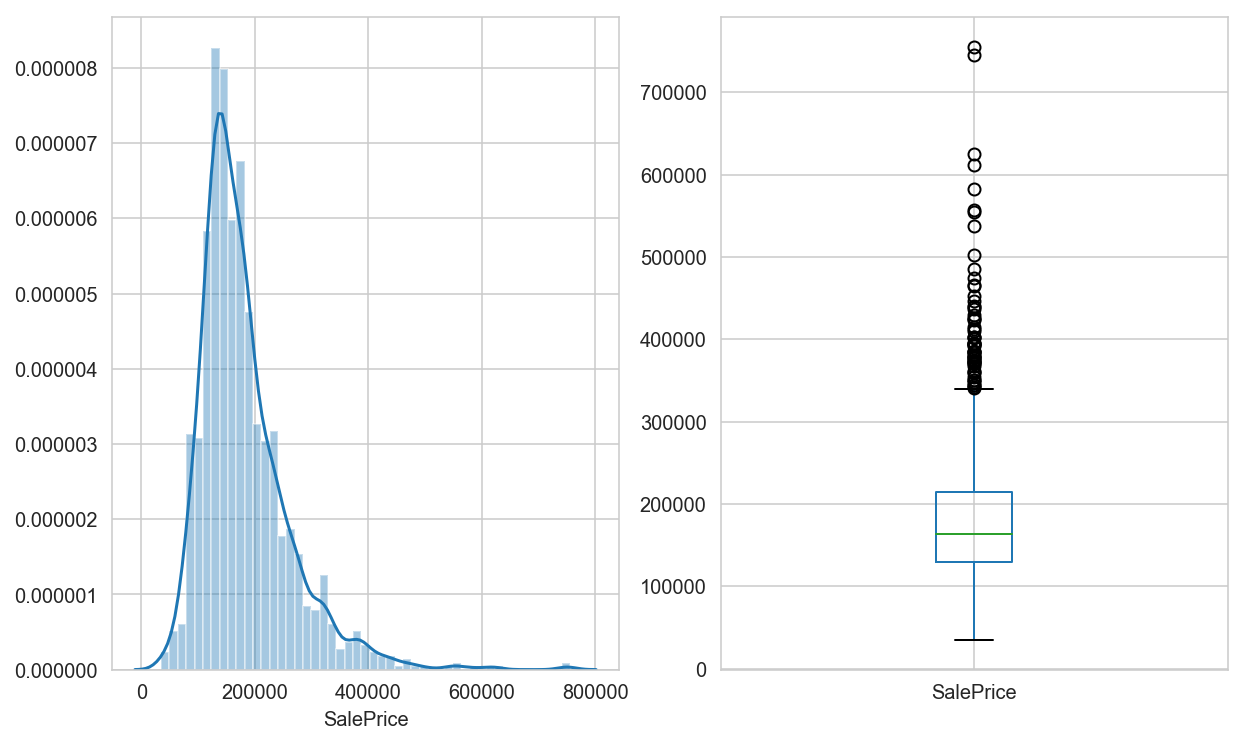

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(house['SalePrice'],ax=ax1)
house['SalePrice'].plot.box(ax=ax2)

The sales price:
- Deivates from the normal distribution
- Positvely skewed, *check [Skewness](https://en.wikipedia.org/wiki/Skewness)*
- There are many outliers

In [10]:
print ('Skewness of Salesprice is {}'.format(house.SalePrice.skew()))
print ('Kurtosis of Salesprice is {}'.format(house.SalePrice.kurt()))

Skewness of Salesprice is 1.8828757597682129
Kurtosis of Salesprice is 6.536281860064529


SalePrice is the target variable.<br>
Fit data to normal distribution ,see this (http://firsttimeprogrammer.blogspot.com/2014/07/how-to-fit-data-to-normal-distribution.html) <br>
Maximum Likelihood Estimation (https://medium.com/@rrfd/what-is-maximum-likelihood-estimation-examples-in-python-791153818030)<br>
Q-Q plot (https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

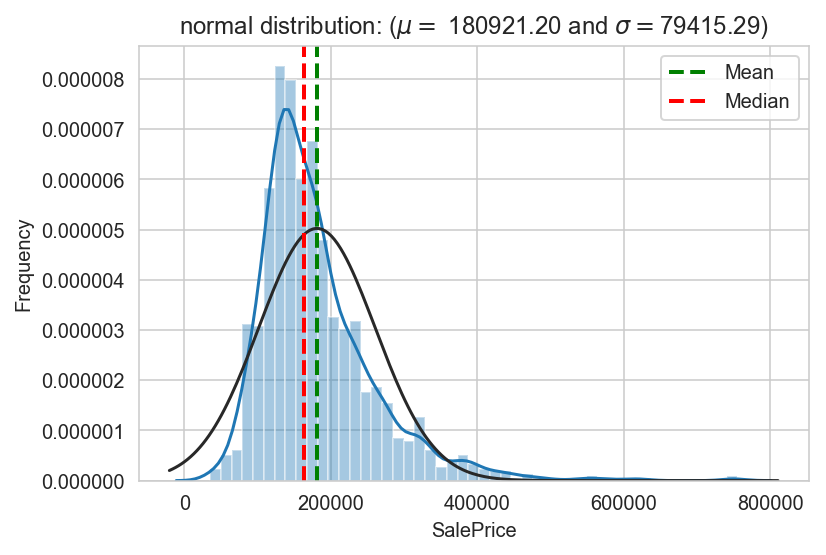

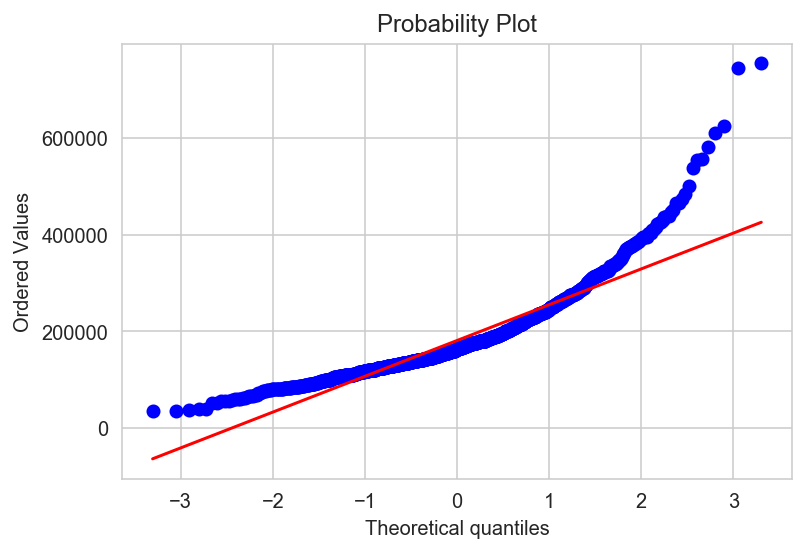

In [6]:
sns.distplot(house['SalePrice'], fit=ss.norm,)

#obtain fitted parameters 
(mu, sigma) = ss.norm.fit(house['SalePrice'])
plt.title('normal distribution: ($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(mu,sigma))
#plot the distribution

plt.ylabel('Frequency')
plt.xlabel('SalePrice')
plt.axvline(house.SalePrice.mean(), color='g', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(house.SalePrice.median(), color='r', linestyle='dashed', linewidth=2, label='Median')
plt.legend()

#Q-Q plot
fig=plt.figure()
qq=ss.probplot(house['SalePrice'],plot=plt)
plt.show()

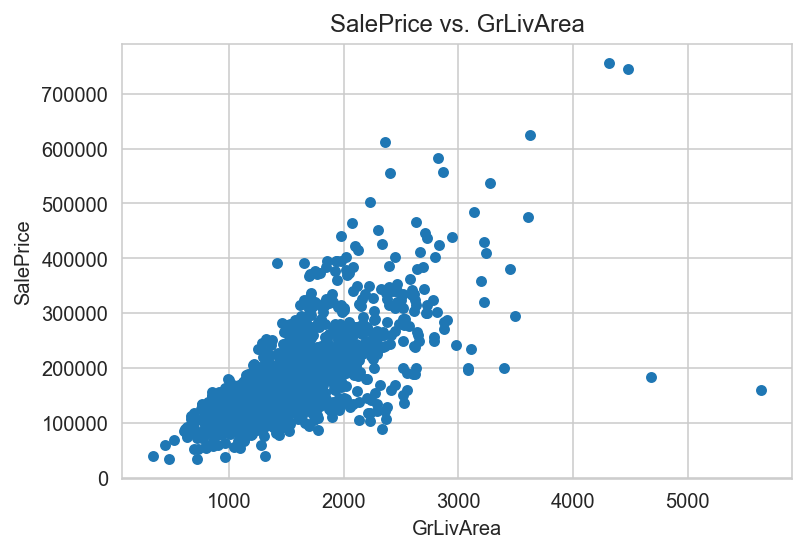

In [7]:
house.plot(x='GrLivArea',y='SalePrice',kind='scatter')
plt.title('SalePrice vs. GrLivArea')
plt.show()

From the scatter plot, we can see that 2 points at bottom right two with large GrLivArea (Above grade (ground) living area square feet) with relatively low SalePrice. 

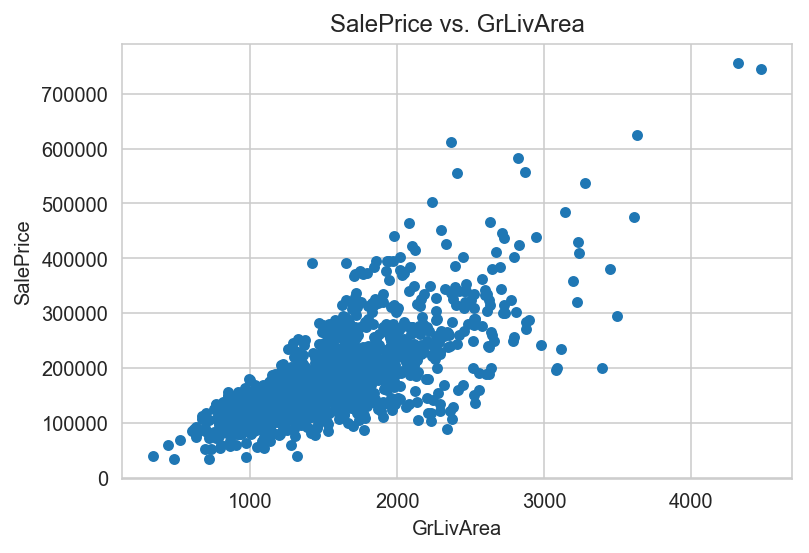

In [167]:
#Remove these two specific data points
house = house.drop(house[(house['GrLivArea']>4000) & (house['SalePrice']<300000)].index)

#check again
house.plot(x='GrLivArea',y='SalePrice',kind='scatter')
plt.title('SalePrice vs. GrLivArea')
plt.show()

Since there are many features here and it could be tedious to look into each feature one by one. Use a correlation matrix to help us understand which features are relevant to each other. <br>
In addition, we can also explore the important feautres to the target variable - `SalePrice`

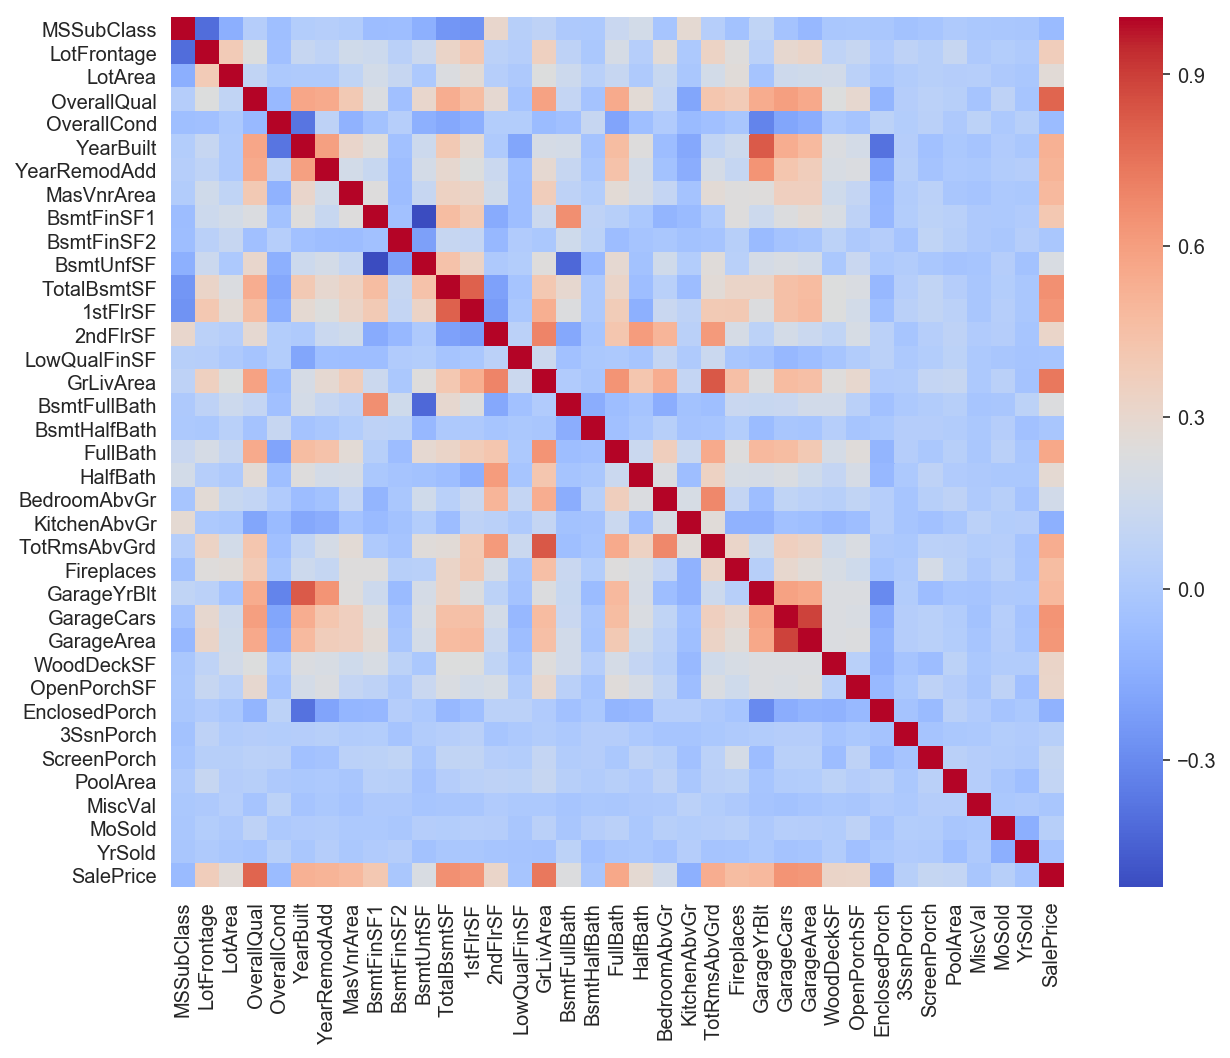

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(house.corr(),cmap='coolwarm')

Features relevant to `SalePrice`
From the correlation heatmap above, we can immediately see that two features standing out which are probably most relevant to our target variable:
    - `OverallQual`:Rates the overall material and finish of the house
    - `GrLivArea`: Above grade (ground) living area square feet
Let's zoom in to which are the features that are close to the target variable.

In [34]:
def corr_heatmap_zoom_nomask(df, k, target):
    """ Display a seaborn correlation heatmap with a more focused view
        df--> DataFrame
        k--> number of variables for heatmap
        target--> target varaible"""
    
    corrmat = df.corr()
    cols = corrmat.nlargest(k,target)[target].index
    cm = np.corrcoef(df[cols].values.T)
    fig = sns.heatmap(cm, annot=True, square=True, fmt='.2f', yticklabels=cols.values, 
                      xticklabels=cols.values,cmap='coolwarm')
    plt.show()
    return cols

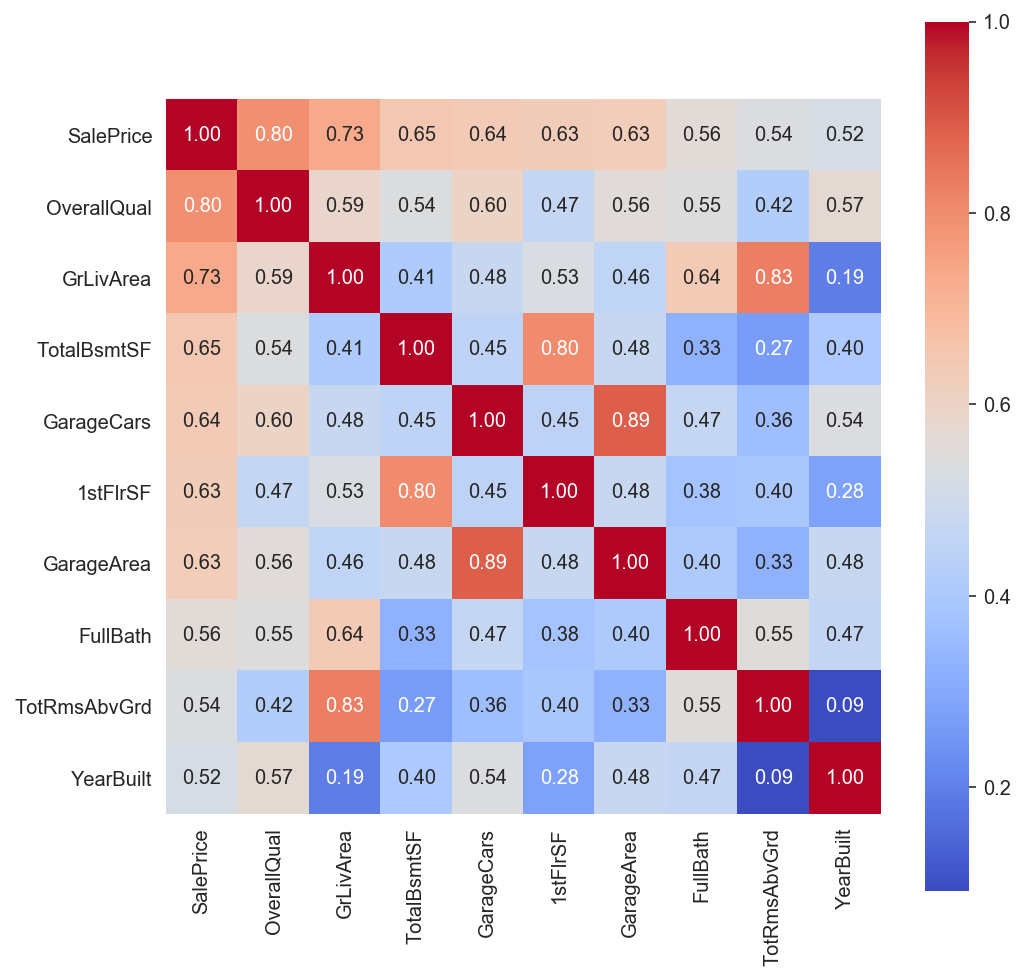

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
       '1stFlrSF', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [45]:
plt.figure(figsize=(8,8))
corr_heatmap_zoom(house,10,'SalePrice')

According to the correlation heatmap above, it is observd that:
- `OverallQual`, `GrLivArea`,`TotalBsmtSF`, `GarageCars`, `1stFlrSF` and `GrageArea` are highly correlated to the target `SalePrice`
- `FullBath`, `TotRmsAbvGrd` and `YearBuilt` are slightly less correlated with `SalePrice`
- `GarageCars` is also strong correlated `GrageArea`. This is possibly due to the fact a larger grage is needed if the resident has more cars
- `TotalBsmtSF` and `1stFlrSF` also have strong correlation. According to the data description:
    - `TotalBsmfSF` is total square feet of basement area
    - `1stFlrSF` is First Floor square feet
It is probably due to the fact most of the basement has the same floor area since it is just beneth 1st floor. 

Since there are some correlation among features as well, for example, `GarageCars` and `GrageArea`, `TotalBsmtSF` and `1stFlrSF`, we will keep the stronger correlated features for further analysis. 

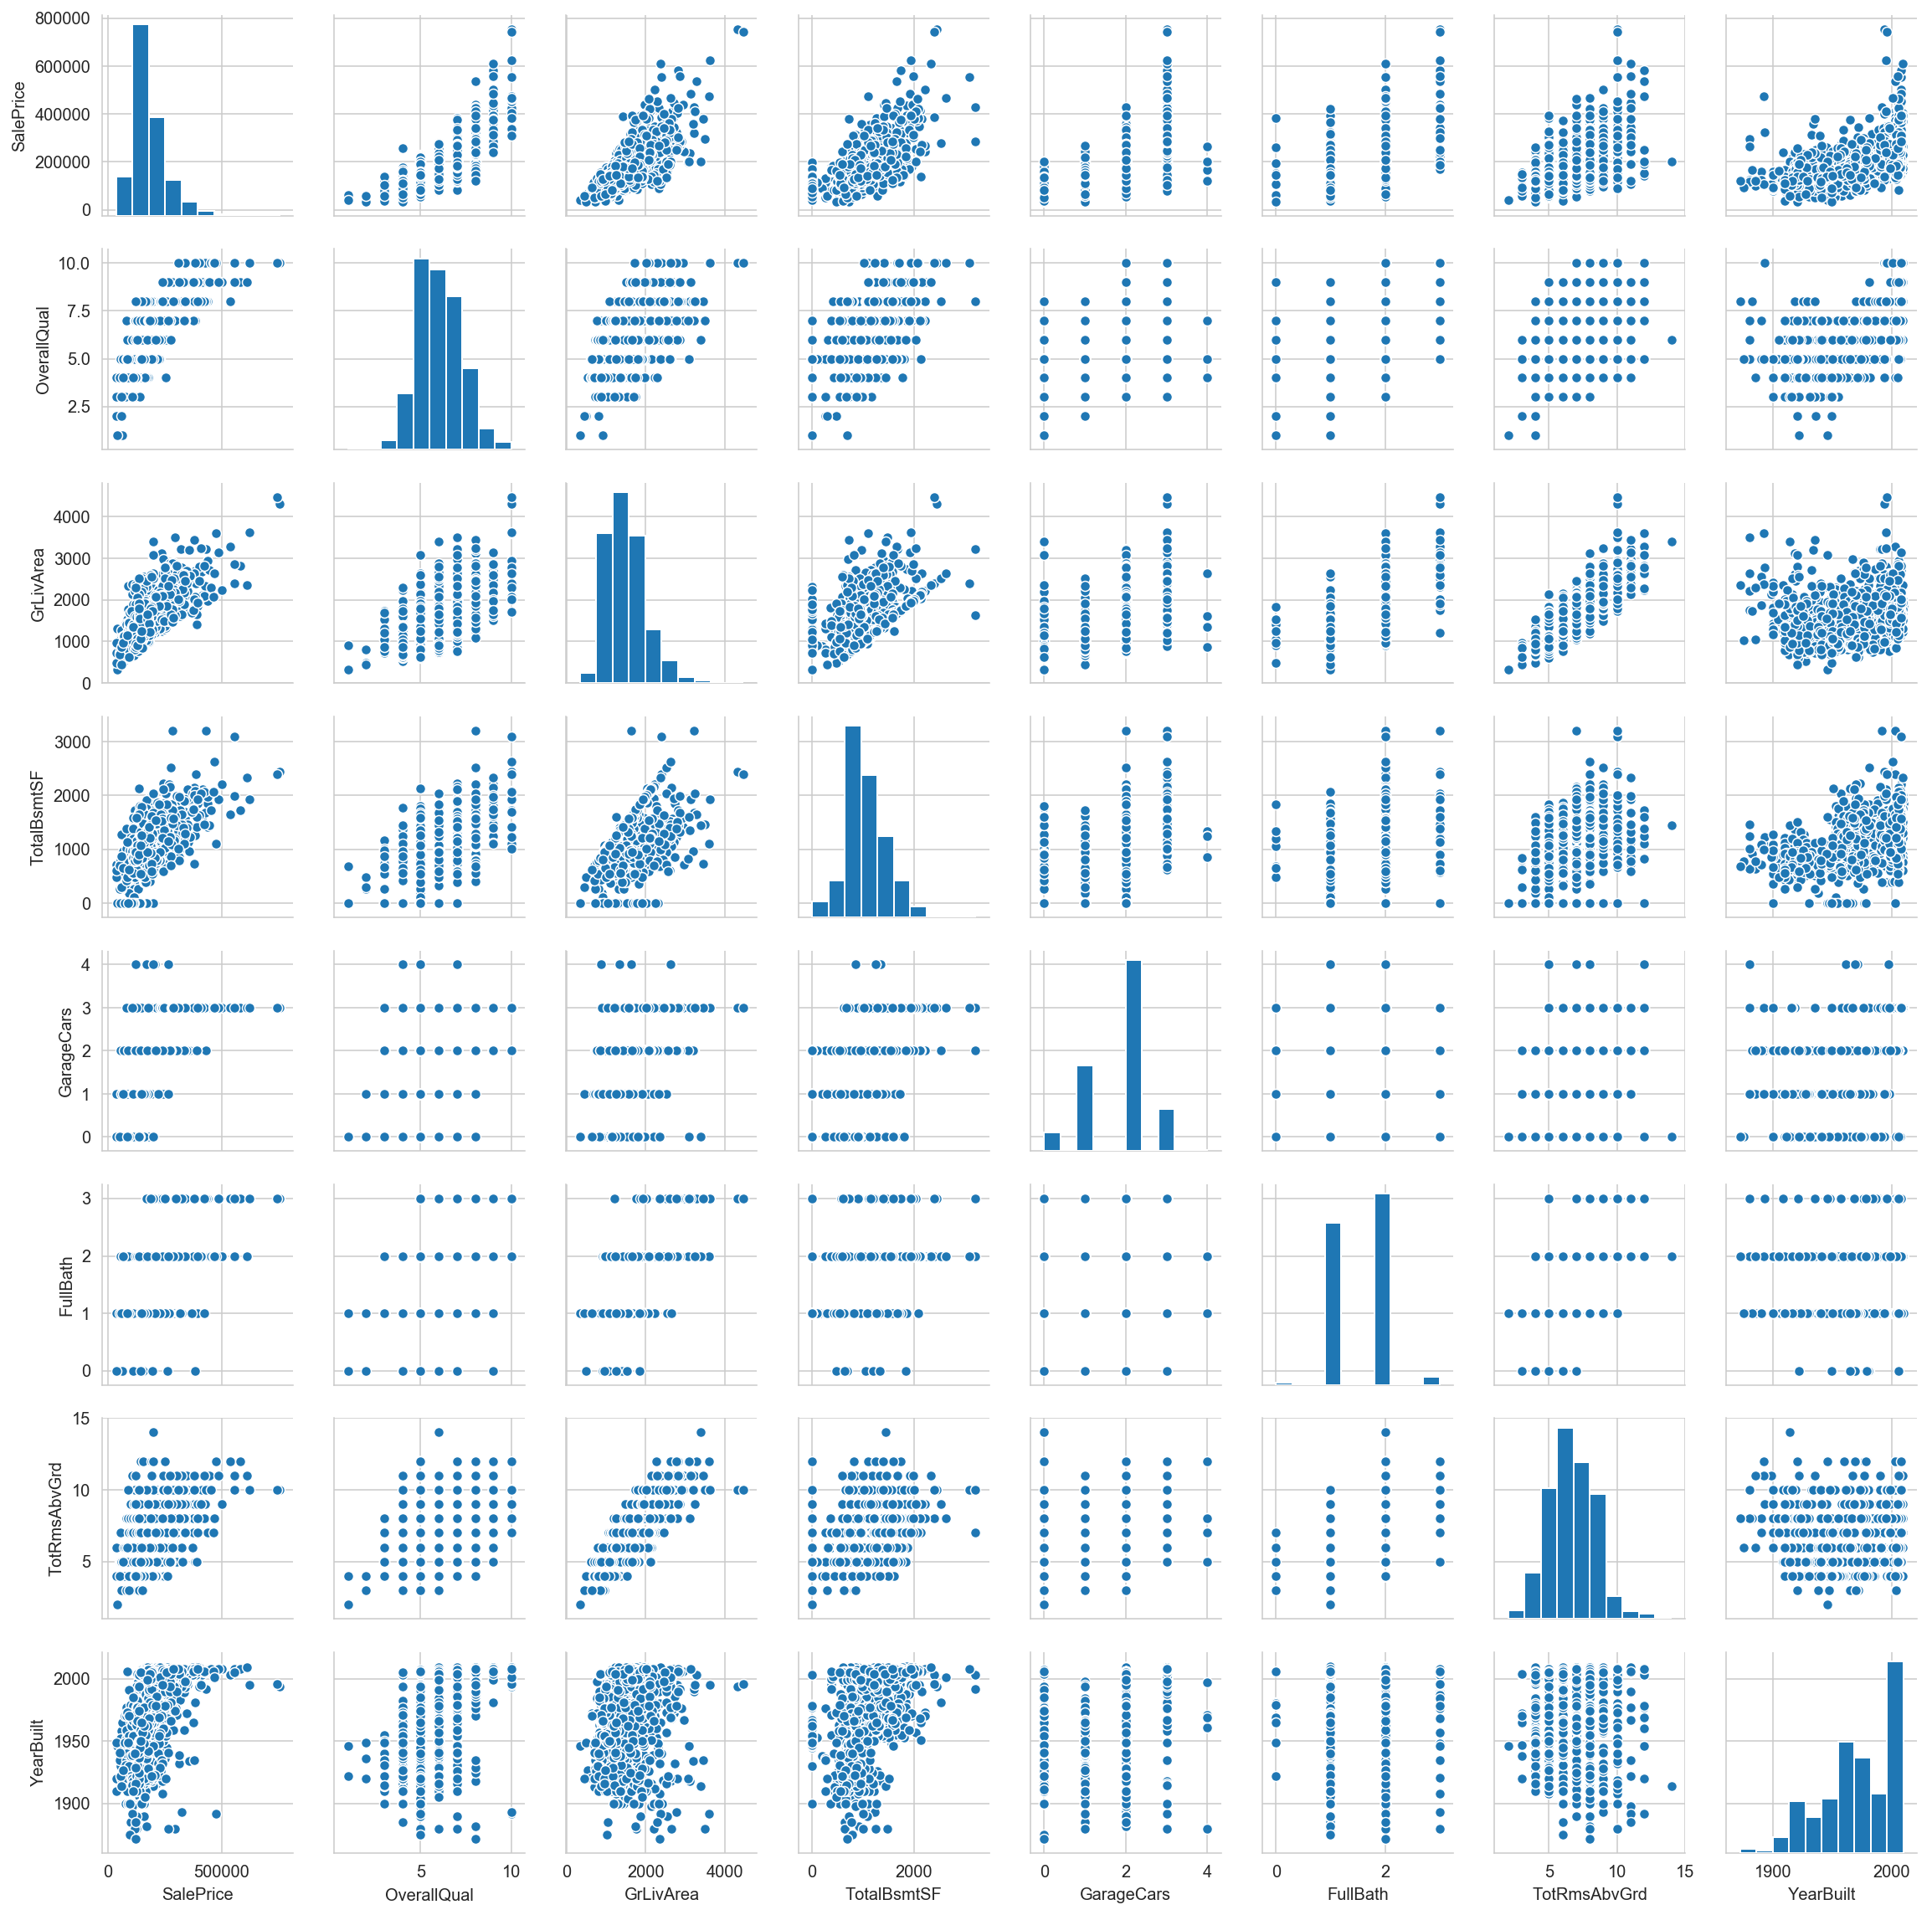

In [48]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
       'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(house[cols],size=2)
plt.show()

### Handle missing values
Missing data are important as they provide opportunities to reduce the sample size, however, we might lose some useful information as well. It is important we ensure that the missing values are handled properly so they are not biased. 

In [154]:
# Check features with more than 70% missing values
missing=house.isnull().sum().sort_values(ascending=False)/len(house)
missing[missing>0.7].index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

In [168]:
# Drop 'PoolQC', 'MiscFeature', 'Alley', 'Fence'
house.drop(labels=['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [169]:
# Drop Id Column
house.drop(['Id'], axis=1, inplace=True)

In [26]:
def check_missing(df):
    """ display missing data in a DataFrame in terms of number as well as percentage 
        sorted in descending order, and display all missing values only
        df --> DataFrame
        """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total','Percent'])
    return missing_data[missing_data['Total']!=0]

In [170]:
check_missing(house)

,Total,Percent
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556
BsmtExposure,38,0.026063
BsmtFinType2,38,0.026063
BsmtFinType1,37,0.025377


After dropped those features with more than 70% missing values, it seems there are only two features contain relativley larger proportion of missing values : `FirepalceQu` and `LotFrontage`.<br>
It is also observed the features starting with `Garage*` have the same number of missing values, this perhaps points to the fact these features belong to the same object - garage. <br>
The rest of features contain relatively small proportion. <br>
Prior to handle these missing values, we can do some simple visualisation to see whether we can discard some of the features. 

`FireplaceQu`: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

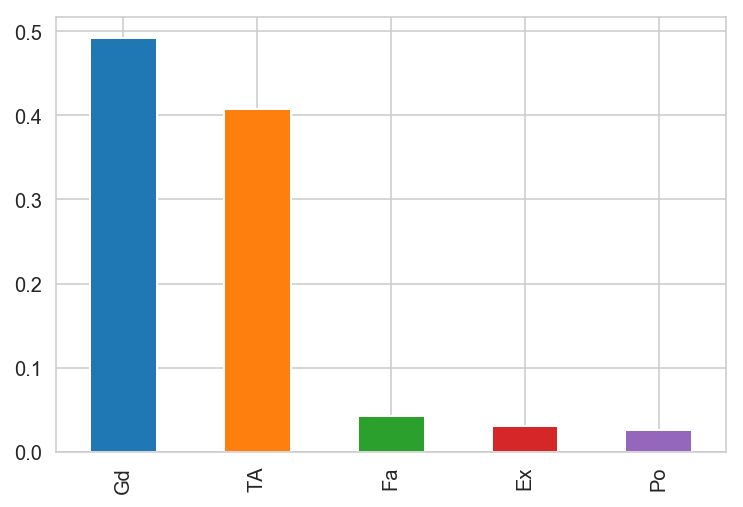

In [29]:
house['FireplaceQu'].value_counts(normalize=True).plot.bar()

According to the data description, if there is no firepalce, it should be described as NA. Thus, we will repalce `NaN` with NA.

In [171]:
house['FireplaceQu'].fillna('NA',inplace=True)

`LotFrontage` is the Linear feet of street connected to property,it might be relevant to the property price. Intuitively, probably some people prefer to live away or neaer to the street. 

In [172]:
house['LotFrontage'].isnull().sum()

259

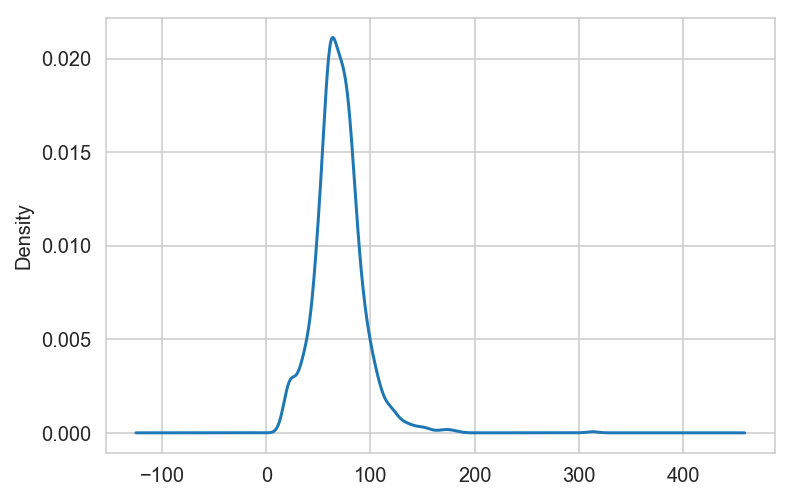

In [173]:
house['LotFrontage'].plot.kde()

It is observed that the `LotFrontage` is quite normally distributed and we can impute the null values with its mean.

In [174]:
#impute with mean
house['LotFrontage'].fillna(house['LotFrontage'].mean(),inplace=True)

Since the rest missing feautures has very little percentage , we can just drop them.

In [175]:
#num of rows before drop
print (house.shape[0])

1458


In [177]:
cols = check_missing(house).index.values.tolist()
house.dropna(subset=cols,inplace=True)

In [178]:
print (house.shape[0])

1336


It seems after dropping these missing values, only 23 rows are removed.

In [85]:
#sanity check to make sure no missing values remaiend
check_missing(house).sum()[0]

0.0

In [179]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


# Feature Engineering
Feature enginnering is important as we are trying to reduce the size of features. <br>
Based on the data description, it is observed that `MSSubClass` is used to identify the type of dwelling invoved in the sale, however, it contains nearly 50% are type NA, which means unknown. In addition, the type class ia not defined clearly. As we can see some classes contain years while some are not. From the correaltion heatmap, we can also observe a weak correaltion bewteen `MSSubClass` and `SalePrice`.

In [111]:
# house['MSSubClass'].value_counts(normalize=True)

In [180]:
house.drop('MSSubClass',axis=1,inplace=True)

In [181]:
#check current dataframe dtypes
house.dtypes.value_counts()

object     39
int64      33
float64     3
dtype: int64

In [186]:
# #save cleaned file
# house.to_csv('house_1.csv',index=False)

According to data description, `Condition1` and `Condition2` both refer to *Proximity to various conditions*, thus we can combine them into a new feature `condition`

In [192]:
house['Same_Condition']=house['Condition1'] == house['Condition2']

In [194]:
house.drop('Condition2',axis=1,inplace=True)

In [195]:
#similarly Exterior1st, Exterior2nd 
house['Same_exterior']=house['Exterior1st'] == house['Exterior2nd']
house.drop('Exterior2nd',axis=1, inplace=True)

In [196]:
#combine BsmtFinSF1 and BsmtFinSF2  and divided by TotalBsmtSF to get Bsmt_per_sf_done
house['Bsmt_per_sf_done']=(house['BsmtFinSF1']+house['BsmtFinSF2'])/house['TotalBsmtSF']

In [197]:
#drop BsmtFinSF1,BsmtFinSF2  and TotalBsmtSF
house.drop(['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF'],axis=1,inplace=True)

In [198]:
#get low quality proportion
house['low_qual_per'] =house['LowQualFinSF']/(house['1stFlrSF'] + house['2ndFlrSF'])
house.drop(['LowQualFinSF','1stFlrSF','2ndFlrSF'],axis=1, inplace=True)

From data description, we notice that `TotRmsAbvGrd` is the total rooms above ground but does not include bathrooms, therefore, we can add bathrooms to get total rooms in the house.

In [201]:
#get total rooms above ground
house['total_rm'] = house['TotRmsAbvGrd'] + house['BsmtFullBath'] + house['BsmtHalfBath']*0.5 + house['FullBath']+ house['HalfBath']*0.5

In [203]:
house.drop(['BedroomAbvGr','TotRmsAbvGrd','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1, inplace=True)

In [204]:
#combine deck and porch
house['total_deck_porch'] = house['WoodDeckSF'] + house['OpenPorchSF'] + house['EnclosedPorch'] + house['3SsnPorch'] + house['ScreenPorch']
house.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1, inplace=True)

In [209]:
#take a look at current dataframe
# house.head()

In [208]:
#create house age and remodeled age
house['age'] = house['YrSold'] - house['YearBuilt']
house['age_remodel'] = house['YrSold'] - house['YearRemodAdd']
house.drop(['YearBuilt','YearRemodAdd'],axis=1, inplace=True)

In [210]:
print (house.columns)

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice', 'Same_Condition',
       'Same_exterior', 'Bsmt_per_sf_done', 'low_qual_per', 'total_rm',
       'total_deck_porch', 'age', 'age_remodel'],
      dtype='object')


In [213]:
#check the quality, cond features
house[['OverallQual', 'OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond']].head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,GarageQual,GarageCond
0,7,5,Gd,TA,Gd,TA,TA,TA
1,6,8,TA,TA,Gd,TA,TA,TA
2,7,5,Gd,TA,Gd,TA,TA,TA
3,7,5,TA,TA,TA,Gd,TA,TA
4,8,5,Gd,TA,Gd,TA,TA,TA


In [214]:
house.OverallQual.value_counts()

6     359
5     351
7     312
8     165
4      81
9      43
10     15
3       8
2       2
Name: OverallQual, dtype: int64

In [215]:
house.OverallCond.value_counts()

5    768
6    233
7    183
8     68
4     46
9     20
3     15
2      3
Name: OverallCond, dtype: int64

In [216]:
#simplify 
house['OverallQual'] = house['OverallQual'].replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
house['OverallCond'] = house['OverallCond'].replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })

In [219]:
house[['ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond']]=house[['ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond']].replace({
    'Po':1,'Fa':2,'TA':2,'Gd':3,'Ex':3
})

In [220]:
house[['OverallQual', 'OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond']].head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,GarageQual,GarageCond
0,3,2,3,2,3,2,2,2
1,2,3,2,2,3,2,2,2
2,3,2,3,2,3,2,2,2
3,3,2,2,2,2,3,2,2
4,3,2,3,2,3,2,2,2


In [221]:
house['OverallScore']=(house['OverallQual'] + house['OverallCond'])/2
house['ExterScore'] = (house['ExterQual'] + house['ExterCond'])/2
house['BsmtScore'] = (house['BsmtQual'] + house['BsmtCond'])/2
house['GarageScore'] = (house['GarageQual'] + house['GarageCond'])/2
house.drop(['OverallQual', 'OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond'],axis=1,inplace=True)

In [226]:
#create a datetime column YrMon
from datetime import datetime

In [230]:
def get_datetime(row):
    return datetime(year=row['YrSold'],month=row['MoSold'],day=1)

In [234]:
house['YrMon'] = house.apply(get_datetime,axis=1)

In [237]:
house[['HeatingQC','FireplaceQu']]=house[['HeatingQC','FireplaceQu']].replace({
    'NA':0,'Po':1,'Fa':2,'TA':2,'Gd':3,'Ex':3
})

In [239]:
house.select_dtypes(include='O').head(1)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,CompShg,VinylSd,BrkFace,PConc,No,GLQ,Unf,GasA,Y,SBrkr,Gd,Typ,Attchd,RFn,Y,WD,Normal


In [240]:
house.select_dtypes(exclude='O').head(1)

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,HeatingQC,GrLivArea,KitchenAbvGr,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Same_Condition,Same_exterior,Bsmt_per_sf_done,low_qual_per,total_rm,total_deck_porch,age,age_remodel,OverallScore,ExterScore,BsmtScore,GarageScore,YrMon
0,65.0,8450,196.0,150,3,1710,1,0,0,2003.0,2,548,0,0,2,2008,208500,True,True,0.824766,0.0,11.5,61,5,5,2.5,2.5,2.5,2.0,2008-02-01


In [241]:
#save cleaned file
house.to_csv('house_2.csv',index=False)

# EDA

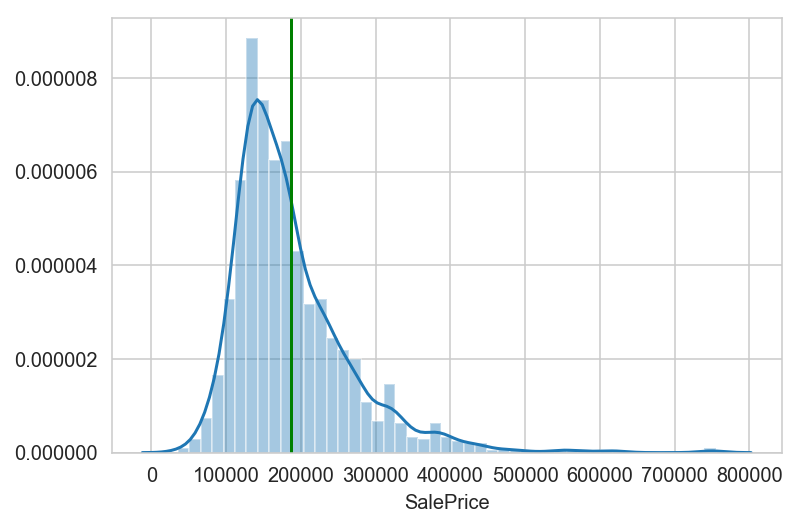

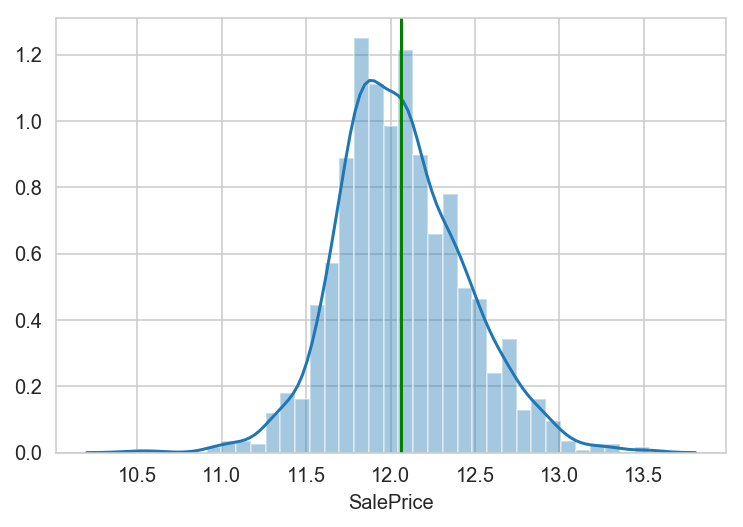

In [245]:
sns.distplot(house['SalePrice'])
plt.axvline(house['SalePrice'].mean(),color='g')
plt.show()
sns.distplot(np.log(house['SalePrice']))
plt.axvline(np.log(house['SalePrice']).mean(),color='g')

It is observed that `log(SalePrice)` distributes more normally. In addition, apply log to scale SalePrice would reduce the effect of outliers such as extreme expensive house.

In [246]:
house['log_sale_price'] = np.log(house['SalePrice'])

In [262]:
price = house[['SalePrice']]

In [263]:
house.drop('SalePrice',axis=1, inplace=True)

In [267]:
price.to_csv('price_clean.csv',index=False)

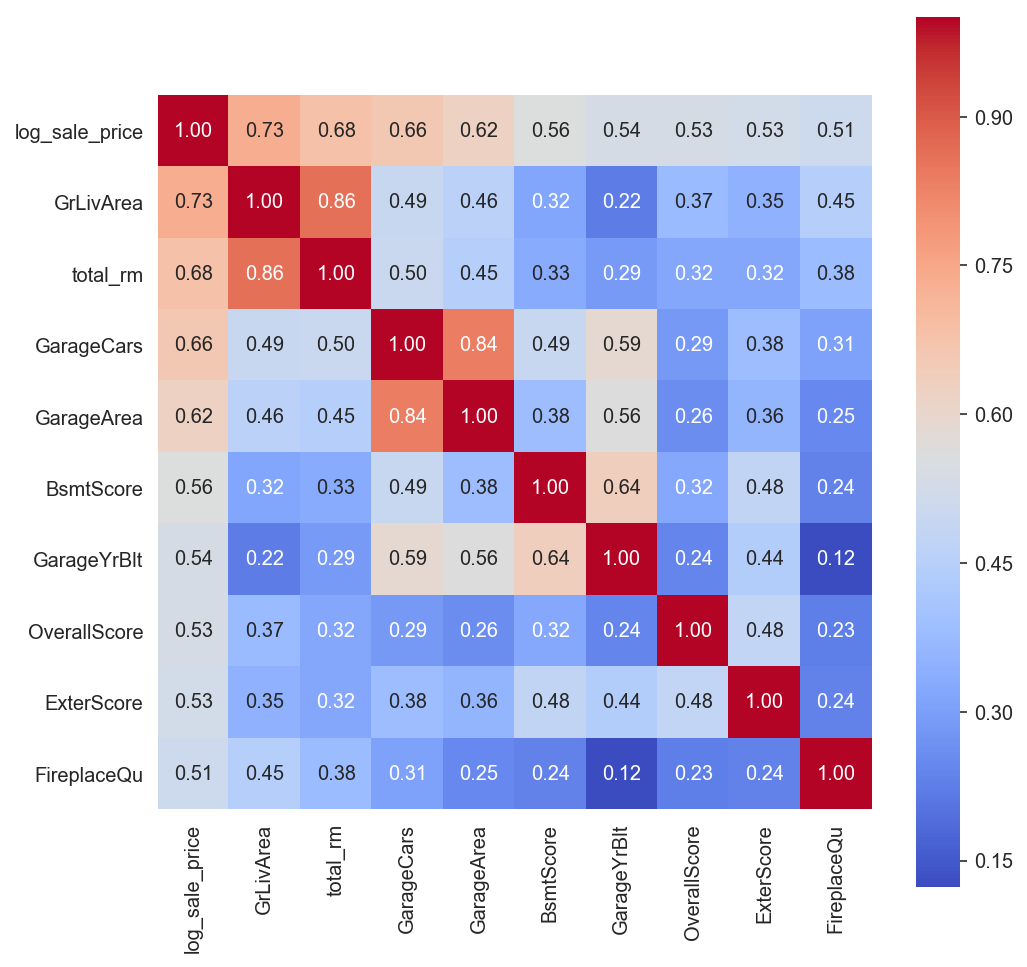

Index(['log_sale_price', 'GrLivArea', 'total_rm', 'GarageCars', 'GarageArea',
       'BsmtScore', 'GarageYrBlt', 'OverallScore', 'ExterScore',
       'FireplaceQu'],
      dtype='object')

In [271]:
plt.figure(figsize=(8,8))
corr_heatmap_zoom_nomask(house,10,'log_sale_price')

As mentioned earlier, `GarageCars` and `GarageArea` are highly correalted. The newly created feature `total_rm` is also higly correlated with `GrLivArea`. In this case, we can drop the `GarageArea` and `total_rm` since they have slighly lower correlation with `log_sale_price`.

In [4]:
house.drop(['GarageArea','total_rm'],axis=1, inplace=True)

In [5]:
#drop 'MoSold', 'YrSold'
house.drop(['MoSold', 'YrSold'], axis=1, inplace=True)

## Fixed features
A quick recap on my task:<br>
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

In [78]:
house['Date'] = pd.to_datetime(house['YrMon'])
house.drop('YrMon',axis=1,inplace=True)

In [79]:
print (house.columns)

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'MasVnrType', 'MasVnrArea', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'GrLivArea', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'PavedDrive', 'PoolArea', 'MiscVal',
       'SaleType', 'SaleCondition', 'Same_Condition', 'Same_exterior',
       'Bsmt_per_sf_done', 'low_qual_per', 'total_deck_porch', 'age',
       'age_remodel', 'OverallScore', 'ExterScore', 'BsmtScore', 'GarageScore',
       'log_sale_price', 'Date'],
      dtype='object')


In [81]:
fixed_features = ['Street','MSZoning','LotFrontage','LotArea','LotShape',
       'LandContour','LotConfig', 'LandSlope', 'Neighborhood',
                  'Condition1', 'BldgType', 'HouseStyle','Foundation',
                 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF',
                 'GrLivArea','KitchenAbvGr','GarageType', 'GarageYrBlt',
                 'GarageFinish', 'GarageCars','PoolArea','Bsmt_per_sf_done',
                 'low_qual_per', 'total_deck_porch','age',
                   'age_remodel','log_sale_price','Date']

In [82]:
change_features  = ['Utilities', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'PavedDrive', 'MiscVal', 'SaleType', 'SaleCondition', 'Same_Condition', 'Same_exterior', 'OverallScore', 'ExterScore', 'BsmtScore', 'GarageScore', 'YrMon', 'log_sale_price','Date']

In [83]:
fixed_df = house[fixed_features].copy()

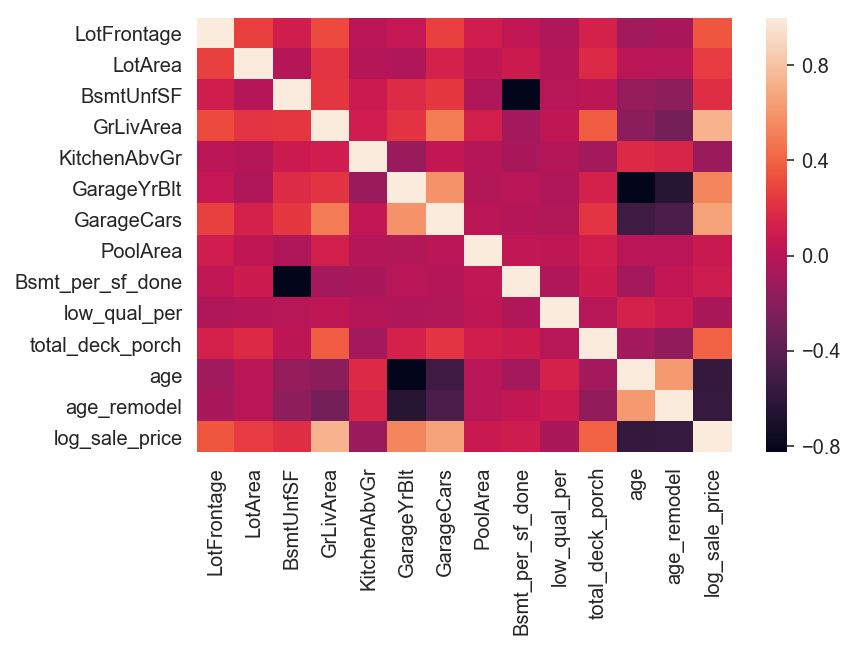

In [38]:
sns.heatmap(fixed_df.corr())

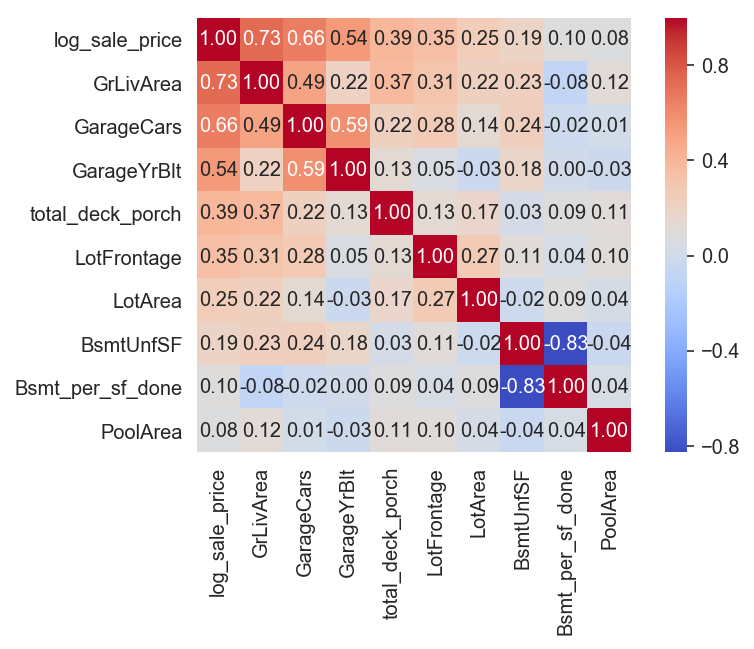

Index(['log_sale_price', 'GrLivArea', 'GarageCars', 'GarageYrBlt',
       'total_deck_porch', 'LotFrontage', 'LotArea', 'BsmtUnfSF',
       'Bsmt_per_sf_done', 'PoolArea'],
      dtype='object')

In [36]:
corr_heatmap_zoom_nomask(fixed_df,10,'log_sale_price')

Among fixed features, there are some features highly correlated with each other. 

In [84]:
# remove 'Bsmt_per_sf_done' and 'GarageYrBlt'
fixed_df.drop(['Bsmt_per_sf_done','GarageYrBlt'],axis=1,inplace=True)

In [45]:
#get train index, test index
#pre-2010
# train_index = house[house['YrMon']<'2010'].index
# test_index = house[house['YrMon']>='2010'].index

In [85]:
cat_features = fixed_df.select_dtypes(include='O').columns

In [87]:
for f in cat_features:
    f_list = 'f'+'_' + f
    f_list=pd.get_dummies(fixed_df[f], prefix=f, drop_first=True)
    temp = fixed_df.join(f_list)
    fixed_df=temp

In [88]:
temp_col = fixed_df.columns.values.tolist()
to_keep = [col for col in temp_col if col not in cat_features]

In [89]:
fixed_df_final = fixed_df[to_keep]

In [90]:
fixed_df_final.head(3)

,LotFrontage,LotArea,BsmtUnfSF,GrLivArea,KitchenAbvGr,GarageCars,PoolArea,low_qual_per,total_deck_porch,age,...,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf
0,65.0,8450,150,1710,1,2,0,0.0,61,5,...,0,0,1,1,0,0,0,0,1,0
1,80.0,9600,284,1262,1,2,0,0.0,298,31,...,0,0,1,1,0,0,0,0,1,0
2,68.0,11250,434,1786,1,2,0,0.0,42,7,...,0,0,1,1,0,0,0,0,1,0


In [57]:
# 'log_sale_price' in fixed_df_final.columns

In [92]:
fixed_train=fixed_df_final[fixed_df_final['Date']<'2010']
fixed_test=fixed_df_final[fixed_df_final['Date']>='2010']

In [96]:
fixed_train.drop('Date',axis=1, inplace=True)
fixed_test.drop('Date',axis=1, inplace=True)

In [104]:
X_train,y_train=fixed_train.loc[:, fixed_train.columns != 'log_sale_price'], fixed_train.loc[:, fixed_train.columns == 'log_sale_price']
X_test,y_test = fixed_test.loc[:,fixed_test.columns != 'log_sale_price'], fixed_test.loc[:,fixed_test.columns == 'log_sale_price']

In [105]:
scaler=StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [107]:
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [108]:
#try linear regression first
lr = LinearRegression()

In [109]:
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print ('rmse of linear regression model: ', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

rmse of linear regression model:  0.133913586791888


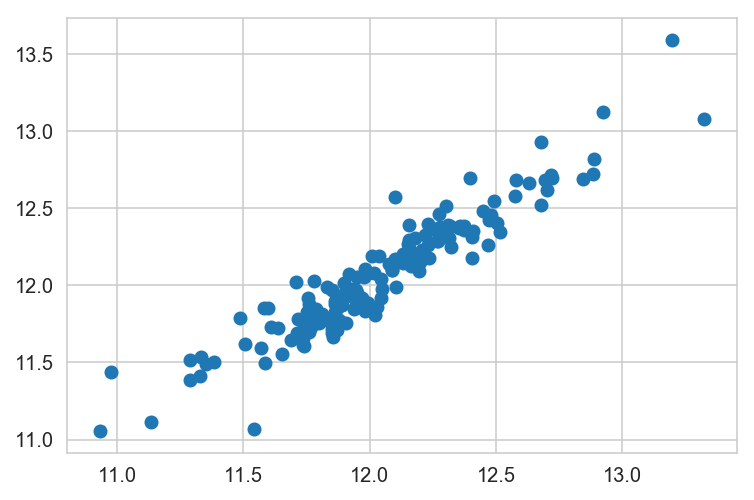

In [112]:
plt.scatter(y_test,y_pred)

In [114]:
#statsmodel osl
from statsmodels.api import OLS
model = OLS(y_train.values,X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.087
Method:                 Least Squares   F-statistic:                  0.009891
Date:                Thu, 24 Jan 2019   Prob (F-statistic):               1.00
Time:                        08:10:31   Log-Likelihood:                -4597.5
No. Observations:                1176   AIC:                             9385.
Df Residuals:                    1081   BIC:                             9867.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
LotFrontage              0.0099      0.523      0.019      0.985      -1.017       1.037
LotArea                  0.0334      0.587      0.057      0.955      -1.118       1.185
BsmtUnfSF               -0.0089      0.626     -0.014      0.989      -1.237       1.220
GrLivArea                0.2022      0.770      0.263      0.793      -1.309       1.713
KitchenAbvGr            -0.0257      0.646     -0.040      0.968      -1.293       1.241
GarageCars               0.0357      0.581      0.061      0.951      -1.104       1.176
PoolArea                 0.0021      0.394      0.005      0.996      -0.771       0.776
low_qual_per            -0.0065      0.412     -0.016      0.987      -0.814       0.801
total_deck_porch         0.0236      0.445      0.053      0.958      -0.849       0.896
age                     -0.0730      1.136     -0.064      0.949      -2.301       2.155
age_remodel             -0.0454      0.546     -0.083      0.934      -1.117       1.027
Street_Pave              0.0030      0.436      0.007      0.994      -0.852       0.858
MSZoning_FV              0.1089      1.620      0.067      0.946      -3.070       3.288
MSZoning_RH              0.0466      0.775      0.060      0.952      -1.474       1.567
MSZoning_RL              0.2113      2.814      0.075      0.940      -5.311       5.734
MSZoning_RM              0.1682      2.346      0.072      0.943      -4.434       4.771
LotShape_IR2             0.0015      0.411      0.004      0.997      -0.805       0.808
LotShape_IR3            -0.0029      0.408     -0.007      0.994      -0.803       0.797
LotShape_Reg             0.0016      0.454      0.004      0.997      -0.890       0.893
LandContour_HLS          0.0048      0.574      0.008      0.993      -1.122       1.132
LandContour_Low          0.0024      0.595      0.004      0.997      -1.165       1.170
LandContour_Lvl         -0.0002      0.664     -0.000      1.000      -1.304       1.303
LotConfig_CulDSac        0.0136      0.472      0.029      0.977      -0.912       0.939
LotConfig_FR2           -0.0077      0.418     -0.019      0.985      -0.828       0.812
LotConfig_FR3           -0.0038      0.393     -0.010      0.992      -0.774       0.767
LotConfig_Inside         0.0019      0.472      0.004      0.997      -0.924       0.928
LandSlope_Mod           -0.0019      0.479     -0.004      0.997      -0.942       0.938
LandSlope_Sev           -0.0177      0.516     -0.034      0.973      -1.030       0.995
Neighborhood_Blueste     0.0012      0.423      0.003      0.998      -0.830       0.832
Neighborhood_BrDale      0.0035      0.639      0.006      0.996      -1.249       1.257
Neighborhood_BrkSide     0.0169      1.015      0.017      0.987      -1.975       2.009
Neighborhood_ClearCr    -0.0037      0.687     -0.005    

By looking at the linear regression model summary, the `GrLivArea` feature has the largest coefficient of 0.2.

In [117]:
#random forest
clf = RandomForestRegressor()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print ('Random forest rmse: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Random forest rmse:  0.16555262031410142


In [122]:
pd.DataFrame(clf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by='Importance',ascending=False).head()

,Importance
GrLivArea,0.397227
age,0.264305
GarageCars,0.091772
age_remodel,0.039049
LotFrontage,0.037122


#### Observation:
The two most important fixed features relevant to sale price are `GrLivArea` and `age`, where:
- `GrLivArea` means the living rea suqare feet, perhaps this determines the value of property
- `age` housing age. From linear regression model coefficients, we know that `age` and `sale price` has negative correlation, this implies the housing price drops when it gets old.

In [ ]:
# A: